# Text Classification with PyTorch

Classification is one of the most common machine learning problems where you need to categorize an instance into one or more categories, usually called
classes or labels. Generally, there are three types of classification:

Binary: In this case, you need to categorize an example as belonging to one of two classes.

Multiclass: There are more than two classes that need to be categorized.

Multilabel: In some cases, examples can have more than one class, e.g., a kind of food can have both carbohydrates and vitamins.

In this project, you’ll build a binary classifier. We will use the following tools:

Python: This is the programming language We will write code in.

PyTorch: This is the Python-based deep learning framework We will use to implement deep learning pipelines.

scikit-learn: We will use this library to process data and select, build, and evaluate machine learning models.

NLTK: We will use this library to download data and process it.

XGBoost: We will use this library to build a boosting ensemble model.

DistilBERT: This pre-trained language model will be fine-tuned on the dataset for classification.

GloVe: We will use GloVe embeddings to obtain contextual feature vectors.

We will work on a question classification problem, where you are tasked to identify the primary category into which a question falls. We will use
the Experimental Data for Question Classification dataset that is available in the nltk.corpus package.



## Task 1: Import Libraries and Explore Dataset

The question classification dataset contains questions labeled into 50 classes, which can be categorized into six main categories. It comes split into
two, a test and train split.

In this project, we will focus on the primary classes:

ABBR: Denotes abbreviations

ENTY: Stands for entities

DESC: Denotes descriptions and abstract concepts

HUM: Denotes human beings

LOC: Denotes locations

NUM: Stands for numeric values

Complete the following steps in the notebook:

Run the import statements in the notebook and confirm that we have no errors.

Download the question classification dataset by executing the corresponding cell.

Familiarize yourself with the dataset by performing the following steps:

Print the size of the data.

Print the first two entries of the training set.

Convert the training and testing data to the pandas DataFrame.

Split the label into the main category and the granular category.



### 1.1 Import libraries

In [2]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import qc, stopwords
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import uniform
from xgboost import XGBClassifier

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from scipy.sparse import csr_matrix
import urllib.request
%matplotlib inline

import transformers
from transformers import MobileBertTokenizer, MobileBertModel

### 1.2 Download Question classification dataset


In [3]:
# Download the Question Classification dataset
nltk.download('qc')
train_tuples = qc.tuples("train.txt")
test_tuples = qc.tuples("test.txt")

[nltk_data] Downloading package qc to /root/nltk_data...
[nltk_data]   Unzipping corpora/qc.zip.


### 1.3 Explore the dataset


In [4]:
# Print the size of the data
print(f"The size of train set: {len(train_tuples)}")
print(f"The size of test set: {len(test_tuples)}")

# Print the first two entries of the train dataset
train_tuples[:2]

# Convert into a pandas dataframe:
train_df = pd.DataFrame(train_tuples, columns =['full_label', "text"])
test_df = pd.DataFrame(test_tuples, columns =['full_label', "text"])
train_df.head()

The size of train set: 5452
The size of test set: 500


,full_label,text
0,DESC:manner,How did serfdom develop in and then leave Russ...
1,ENTY:cremat,What films featured the character Popeye Doyle ?
2,DESC:manner,How can I find a list of celebrities ' real na...
3,ENTY:animal,What fowl grabs the spotlight after the Chines...
4,ABBR:exp,What is the full form of .com ?


### 1.4 Split the label


In [5]:
train_df[['main_cat', 'gran_cat']] = train_df['full_label'].str.split(':', expand=True)
test_df[['main_cat', 'gran_cat']] = test_df['full_label'].str.split(':', expand=True)

In [5]:
train_df.head()

,full_label,text,main_cat,gran_cat
0,DESC:manner,How did serfdom develop in and then leave Russ...,DESC,manner
1,ENTY:cremat,What films featured the character Popeye Doyle ?,ENTY,cremat
2,DESC:manner,How can I find a list of celebrities ' real na...,DESC,manner
3,ENTY:animal,What fowl grabs the spotlight after the Chines...,ENTY,animal
4,ABBR:exp,What is the full form of .com ?,ABBR,exp


In [6]:
# How many categories do they have?
print("***********train***********")
print(f'no of unique classes: {len(train_df["full_label"].unique())}')
print(f'no of  main classes: {len(train_df["main_cat"].unique())}')
print(f'no of granular  classes: {len(train_df["gran_cat"].unique())}')
print("***********test***********")
print(f'no of unique classes: {len(test_df["full_label"].unique())}')
print(f'no of  main classes: {len(test_df["main_cat"].unique())}')
print(f'no of granular  classes: {len(test_df["gran_cat"].unique())}')

# See the distribution of the examples.
print('***********train***********')
print(train_df["main_cat"].value_counts())
print('***********test***********')
print(test_df["main_cat"].value_counts())

# Are all the training labels present in the test set and vice versa?
all_unique_values = set(train_df["full_label"].unique()) | set(test_df["full_label"].unique())
len(all_unique_values)

***********train***********
no of unique classes: 50
no of  main classes: 6
no of granular  classes: 47
***********test***********
no of unique classes: 42
no of  main classes: 6
no of granular  classes: 39
***********train***********
main_cat
ENTY    1250
HUM     1223
DESC    1162
NUM      896
LOC      835
ABBR      86
Name: count, dtype: int64
***********test***********
main_cat
DESC    138
NUM     113
ENTY     94
LOC      81
HUM      65
ABBR      9
Name: count, dtype: int64


50

## Task 2: Preprocess Text

In natural language processing (NLP), freeform text like the questions in our dataset is called unstructured data. We have to preprocess them to 
understand them better and train models.

Common text preprocessing techniques, like lowercase conversion, punctuation removal, and stop word elimination, should be employed thoughtfully 
considering our specific task, domain, and data attributes. For instance, in our dataset, there are question marks at the end of sentences, but
because all the sentences are questions, these question marks don’t provide new information to our model. However, in a different task, where we 
have to distinguish between statements and questions, removing them could eliminate a valuable signal for our model.

In this task, we will apply some cleaning techniques.

Perform the following operations to complete this task:

1. Make a copy of both the training and testing DataFrames. The copies will give us a point of reference.

2. Convert the text in the DataFrames to lowercase. Lowercasing helps reduce the size of the vocabulary. For example, “Data” and “data” become the same 
token, and the same thing happens with “HeLlo” and “Hello,” etc.

3. Remove punctuation from the datasets. This also helps with standardizing text, therefore reducing the vocabulary.

4. Remove stop words from the test DataFrame. We can learn more about stop words and how to remove them using the NLTK library. Exclude the following
words from the stop words list: “which,” “who,” “why,” “how,” “what,” “when,” “where,” “whom.”

5. Encode the labels in the DataFrames. The target is categorical data. To train models, you need to convert them to numbers.

Create a LabelEncoder instance.

Fit the LabelEncoder instance.

Get the label mapping (original labels to encoded labels).

Use the transform() method of the LabelEncoder instance to encode the labels.


### 2.1 Make a copy of the dataframes

In [7]:
train_orig = train_df.copy()
test_orig = test_df.copy()

### 2.2 Convert to lowercase


In [8]:
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

### 2.3 Remove punctuation marks


In [9]:
train_df['text'] = train_df['text'].str.replace('[{}]'.format(string.punctuation), '', regex=True)
test_df['text'] = test_df['text'].str.replace('[{}]'.format(string.punctuation), '', regex=True)

### 2.4 Remove stop words


In [10]:
# Get the English stop words list from nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)
print(f'no of stop words: {len(stop_words)}')
remove_list =["which", "who", "why", "how", "what", "when", "where", "whom"]
stop_words = [word for word in stop_words if word not in remove_list]
print(f'no of stop words: {len(stop_words)}')

# Create a function that takes text and a stop word list and removes the stopwords
def remove_stop_words(text,stop_words):
    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the remove_stop_words function to 'text' columns in both train and test
train_df['text'] = train_df['text'].apply(lambda x: remove_stop_words(x, stop_words))
test_df['text'] = test_df['text'].apply(lambda x: remove_stop_words(x, stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 2.5 Encode the labels


In [11]:
# Create an instance of LabelEncoder
le = LabelEncoder()

# Use .fit to fit labels
le.fit(train_orig['main_cat'])

# Get the mapping (original labels to encoded labels)
label_mapping =  {label: encoded_label for label, encoded_label in zip(le.classes_, le.transform(le.classes_))}
print(label_mapping)

# Use le.tranform to encode the labels
train_df['main_cat'] = le.transform(train_df['main_cat'])
test_df['main_cat'] = le.transform(test_df['main_cat'])

{'ABBR': 0, 'DESC': 1, 'ENTY': 2, 'HUM': 3, 'LOC': 4, 'NUM': 5}


In [13]:
train_df.head()

,full_label,text,main_cat,gran_cat
0,DESC:manner,how serfdom develop leave russia,1,manner
1,ENTY:cremat,what films featured character popeye doyle,2,cremat
2,DESC:manner,how find list celebrities real names,1,manner
3,ENTY:animal,what fowl grabs spotlight chinese year monkey,2,animal
4,ABBR:exp,what full form com,0,exp


In [14]:
test_df.head()

,full_label,text,main_cat,gran_cat
0,NUM:dist,how far denver aspen,5,dist
1,LOC:city,what county modesto california,4,city
2,HUM:desc,who galileo,3,desc
3,DESC:def,what atom,1,def
4,NUM:date,when hawaii become state,5,date


## Task 3: Split the Data

In machine learning, the data is usually divided into three key subsets: training, validation (often called the development or dev set), and a 
test set. We do this to avoid data leakage.

Training set: This is the portion of the data on which the model is trained.

Validation set: The validation set helps fine-tune the model’s hyperparameters.

Test set: The test set is held out and should not be used during training. It is used to evaluate the model’s performance on unseen data.

In the case of the question classification dataset, it’s already divided into training and test sets. However, the training subset needs to be further
split into two subsets. Stratified splitting is a technique where the target variable is used to ensure a similar distribution of classes in both the training and validation sets.

To accomplish this, follow these steps:

1. Put the features (text column) into variables named X and X_test and the target into y and y_test variables.

2. Split the features X and target labels y into training and validation subsets.



### 3.1 Obtain the features and target

In [12]:
X = train_df['text']
y = train_df['main_cat']
X_test = test_df['text']
y_test = test_df['main_cat']

### 3.2 Split train into train and valid sets


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [14]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of X_test: {X_test.shape}')

total_size = len(X_train)+len(X_valid)+len(X_test)
print(f'total dataset size: {total_size}')
print(f'train %: {len(X_train)/total_size*100}')
print(f'valid %: {len(X_valid)/total_size*100}')
print(f'test %: {len(X_test)/total_size*100}')

Shape of X_train: (4634,)
Shape of X_valid: (818,)
Shape of X_test: (500,)
total dataset size: 5952
train %: 77.85618279569893
valid %: 13.743279569892472
test %: 8.400537634408602


## Task 4: Extract Features (BoW)

To train your model, you need to convert text into numerical feature vectors. This process is known as feature extraction. One common method for
feature extraction is the bag-of-words (BoW) model. In BoW, you can create features by selecting a specific vocabulary and counting how often each 
vocabulary item appears in an example.

In the BoW model, there are different ways to score words in a document:

Binary: This approach indicates whether a word is present or absent in a document.

Counts: It counts the number of times each word appears in the documents.

Frequencies: It counts the number of times each word appears in the documents and then divides it by its occurrence in all the documents.

It’s worth noting that in the BoW model, the order of words, which is often semantically important, is disregarded. To capture some of this order 
information, you can use n-grams, where an n-gram is a sequence of n words or tokens. For instance, if n is 2, they’re called bigrams. If n is 3,
you can refer to them as trigrams. Keep in mind that using n-grams can rapidly expand the number of dimensions in our feature space. The feature set
is usually limited to a given number to manage this. The exact number of features you choose should be based on the specific needs of your task and 
the available memory resources.

For this task, you’ll perform the following steps:

1. Instantiate the CountVectorizer object with default parameters and get count feature vectors.

2. Instantiate the CountVectorizer object, utilizing 1-gram and 2-grams, and limiting the vocabulary to the top 8000 most frequent words.

3. Fit the CountVectorizer object on the training set and transform the training, validation, and testing sets using the fitted CountVectorizer object.


### 4.1 Instantiate CountVectorizer


In [15]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

### 4.2 Use N-grams


In [16]:
count_vect = CountVectorizer(ngram_range=(1, 2), max_features=8000)

### 4.3 Fit the CountVectorizer


In [17]:
X_train_counts = count_vect.fit_transform(X_train)
X_valid_counts = count_vect.transform(X_valid)
X_test_counts = count_vect.transform(X_test)

In [18]:
print(X_train_counts.shape)
# Calculate the frequencies
word_frequencies = np.array(X_train_counts.sum(axis=0))[0]
# Get the indexes that would sort the word frequencies
sorted_indexes = np.argsort(word_frequencies)
# Get the vocabulary words corresponding to the indexes
vocabulary_words = np.array(count_vect.get_feature_names_out())
# Get the top and bottom frequent words
top_10_tokens = vocabulary_words[sorted_indexes[-10:]][::-1]
bottom_10_tokens = vocabulary_words[sorted_indexes[:10]]

print("Top 10 frequent tokens:")
print(top_10_tokens)

print("\nBottom 10 frequent tokens:")
print(bottom_10_tokens)

(4634, 8000)
Top 10 frequent tokens:
['what' 'how' 'who' 'many' 'name' 'how many' 'where' 'first' 'when'
 'world']

Bottom 10 frequent tokens:
['president russia' 'portrayed robin' 'portrayed renaud'
 'portrayed prewett' 'portrayed man' 'portrayed maggio' 'portrayed george'
 'portrayed frankie' 'portrayed field' 'portrayed fatman']


## Task 5: Extract Features (TF-IDF)

One limitation of using word counts in the BoW model is that frequently occurring words receive higher scores, even though they might not be the most 
relevant or informative. To address this limitation, you can turn to TF-IDF.

Let’s delve into TF-IDF using an example: Which films featured the character Popeye Doyle?

Term: A term refers to an item in your vocabulary. For instance, in the above example, “films” is a term.

Document: In this context, the entire sentence “Which films featured the character Popeye Doyle?” is considered a document.

Collection: The collection is a group of documents, such as your training dataset.

TF (term frequency) measures how many times a term appears in a document, divided by the total number of terms in the collection. 
IDF (inverse document frequency) assesses how many documents contain a term relative to the total number of documents. Rare words appearing in only
a few documents have higher IDF scores, whereas common words like “what” receive lower scores.

TF-IDF is the mathematical product of TF and IDF. In practice, the equation is modified to prevent division by zero error and to get better results.


In [19]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), max_features=8000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_valid_tfidf = tfidf_vect.transform(X_valid)
X_test_tfidf = tfidf_vect.transform(X_test)

## Task 6: Train a Linear Model

Linear models are widely used in machine learning due to their simplicity, interpretability, efficiency, and ease of use. In classification tasks, 
these models create decision boundaries represented by hyperplanes. It’s important to note that linear models assume the data is linearly separable,
which might not be true in all cases. Some common examples of linear classifiers include logistic regression, perceptron, and linear 
support vector machines (SVM).

For this task, you’ll train a logistic regression model. To complete this task, follow these steps:

1. Instantiate the LogisticRegression model with the random_state variable set to 0.

2. Fit the logistic regression model.

3. Evaluate the trained model’s performance on the datasets.

Define a get_accuraccy() function, which takes in the classifier, TF-IDF vectors, labels, and name of the split (e.g., train, test) as parameters.
Inside the function, make a prediction and use the accuracy_score() method from scikit-learn to calculate accuracy, and then print it.

Evaluate the model on the train-test-validation split.



### 6.1 Fit a logistic regression model

In [20]:
clf = LogisticRegression(random_state=0)

### 6.2 Fit the logistic regression model


In [21]:
clf.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=0)

### 6.3 Evaluate the model


In [22]:
# Define get_accuracy() function
def get_accuracy(clf, X_data_split, y_data_split, split_name):
    y_pred = clf.predict(X_data_split)
    acc_score = accuracy_score(y_data_split, y_pred)
    print(f'Accuracy on {split_name}: {acc_score}')
    return acc_score

# Evaluate the model
get_accuracy(clf, X_train_tfidf, y_train, 'train')
get_accuracy(clf, X_valid_tfidf, y_valid, 'valid')
get_accuracy(clf, X_test_tfidf, y_test, 'test')

Accuracy on train: 0.9589987052222702
Accuracy on valid: 0.8312958435207825
Accuracy on test: 0.842


0.842

## Task 7: Tune Hyperparameters

Hyperparameters are settings that define a model’s structure but are not learned from the data itself. In contrast, data-related variables are called
parameters. The process of finding the best hyperparameter values is called hyperparameter tuning, often done using a separate dataset or 
cross-validation. While manual tuning is possible, a more systematic approach is hyperparameter search. In this method, you specify a range of 
hyperparameters and their values to explore. The scikit-learn library provides tools like GridSearchCV and RandomizedSearchCV to assist with 
this process. You can read this Educative Answer for a more detailed explanation.

Common hyperparameters include the optimization algorithm and the type of regularization. LogisticRegression has four penalty (regularization) options: 
none, L1, L2, and Elasticnet. Different solvers (optimization algorithms) support specific penalties.

To complete this task:

1. Define a LogisticRegression model with the following parameters: random_state=0, solver='saga', penalty='elasticnet', l1_ratio=0.0025, max_iter=500.

2. Train and evaluate this model on all data splits.

3. Do a hyperparameter search using RandomizedSearchCV with the following configurations: n_iter=15, scoring='accuracy', cv=5, random_state=42,
n_jobs=-1.

4. Train a new model on train data using the best hyperparameters obtained from the hyperparameter search.

5. Evaluate this best model on the test dataset.


### 7.1. Example tuning; change the optimizer and regularizer

In [23]:
clf = LogisticRegression(random_state=0, 
solver='saga', penalty='elasticnet', 
l1_ratio=0.0025, max_iter=500)

### 7.2 Example tuning: Train and evaluate


In [24]:
clf.fit(X_train_tfidf, y_train) 
get_accuracy(clf, X_train_tfidf, y_train, 'train')
get_accuracy(clf, X_valid_tfidf, y_valid, 'valid')
get_accuracy(clf, X_test_tfidf, y_test, 'test')

Accuracy on train: 0.9585671126456625
Accuracy on valid: 0.8300733496332519
Accuracy on test: 0.842


0.842

### 7.3 Hyperparameter search


In [25]:
model = LogisticRegression()

# Define hyperparameter grid.
param_dist = {
    'C': uniform(loc=0, scale=4),  # Range for regularization strength (log-scale)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # choice of optimizing algorithm
    'max_iter': np.arange(100, 500, 100),  # Range for maximum iterations
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)

# Fit the randomized search to your data
random_search.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=15, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e9254286040>,
                                        'max_iter': array([100, 200, 300, 400]),
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy')

### 7.4 Train a new model


In [26]:
 # Get the best hyperparameters and corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

# Fit the model on train data
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_tfidf, y_train)

Best Hyperparameters: {'C': 3.4647045830997407, 'max_iter': 400, 'solver': 'liblinear'}
Best Accuracy Score: 0.8183012155144093


LogisticRegression(C=3.4647045830997407, max_iter=400, solver='liblinear')

### 7.5 Evaluate the model


In [27]:
get_accuracy(best_model, X_test_tfidf, y_test, 'test')

Accuracy on test: 0.85


0.85

## Task 8: Train an Ensemble Model

Linear models assume that data is linearly separable, but tree-based models like decision trees don’t make this assumption. Tree-based models use 
decision trees to model the relationship between feature and target variables. Like linear models, tree-based models are easy to train, interpret, 
and use. However, using a single estimator can have drawbacks, including overfitting, reliance on a few features, and lower accuracy. To address 
these issues, ensembling techniques are employed, which combine the decisions of multiple models to enhance predictive power. Some popular ensembling 
methods include bagging, boosting, and stacking.

Bagging (bootstrap aggregation): In bagging, multiple models are trained on different subsets of the data. The decisions of these models are combined
through techniques like voting or averaging. Random forest is an example of a bagging ensemble.

Boosting: In boosting, many weak learners are trained sequentially, with each one focusing on examples that previous learners misclassified. 
The results of these learners are combined using weighted averaging. Algorithms like XGBoost and AdaBoost are popular boosting methods.

Stacking: It involves using different models in the first layer to fit the data, followed by a different model that combines their decisions. It aims 
to leverage the strengths of various model types.

In this task, you’ll train an XGBoost model, which is one of the strongest tabular data classification and regression algorithms.

To complete this task:

1. Instantiate and fit the XGBClassifier model on the training data.

2. Evaluate the model on all data splits.


### 8.1 Instantiate and fit an XGBoost classifier

In [28]:
bst = XGBClassifier()
bst.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### 8.2 Evaluate XGBoost model


In [29]:
get_accuracy(bst, X_train_tfidf, y_train, 'train')
get_accuracy(bst, X_valid_tfidf, y_valid, 'valid')
get_accuracy(bst, X_test_tfidf, y_test, 'test')

Accuracy on train: 0.9091497626240829
Accuracy on valid: 0.7677261613691931
Accuracy on test: 0.82


0.82

## Task 9: Evaluate the Ensemble model

You’ve primarily used accuracy to assess the models, but it’s not always the most suitable evaluation metric for classification, particularly with
imbalanced data. Other essential metrics include precision, recall, and F1 score. These metrics are derived from a confusion matrix that categorizes 
predictions into four categories:

True positives (TP): Correctly predicted positive instances

False positives (FP): Incorrectly predicted positive instances

True negatives (TN): Correctly predicted negative instances

False negatives (FN): Incorrectly predicted negative instances

Here are the key classification evaluation metrics:

Accuracy: The ratio of correct predictions to the total predictions.

Precision: The proportion of true positive predictions among all positive predictions.

Recall: The proportion of true positive predictions among all actual positive instances.

F1 score: A harmonic mean of precision and recall.

In general, you should try to get a high F1 score.

In this task, you’ll broaden your evaluation metrics. To accomplish this, follow these steps:

1. Get the test set predictions from the XGBoost model.

2. Derive the confusion matrix for test predictions.

3. Compute the precision, recall, and F1 score for the same model. Use the average='macro' parameter.

                                                                                  


### 9.1 Obtain predictions

In [30]:
y_pred = bst.predict(X_test_tfidf)

### 9.2 Get confusion matrix


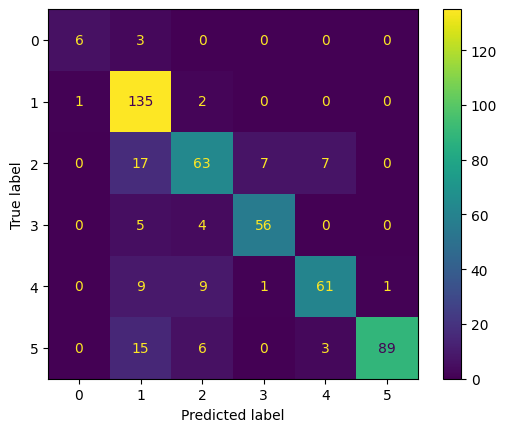

In [31]:
cm = confusion_matrix(y_test, y_pred, labels=bst.classes_)

# Extra: Display the confusion matrix in a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
display_labels=clf.classes_)
disp.plot()
plt.show()

### 9.3 Compute precision, recall and F1 score


In [32]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

In [33]:
print(precision)
print(recall)
print(f1)

0.843980387963854
0.7862293004916509
0.8073450681934734


## Task 10: Define a Neural Network

Neural networks are a subset of machine learning algorithms inspired by the structure of the human brain. You can learn more about neural networks and
deep learning through Educative Answers. The training process of a neural network adjusts its learnable parameters called weights. Unlike traditional 
algorithms, neural networks are called universal approximators meaning they can model complex relationships in data without assuming a specific form 
for the underlying function. They achieve this using non-linear activation functions, which introduce nonlinearity. You’ll use PyTorch, a widely used 
deep learning library, to train neural networks.

In this task, you’ll define a neural network that will learn from TF-IDF vectors obtained in prior tasks.

Perform the following operations to complete this task:

Create a neural network class:

Within the __init__() constructor method, initialize three linear layers. These layers will transform the input data as it passes through the network. 
The input and output dimensions for these layers should be as follows: input - [ 8000, 1024, 256] output - [1024, 256, 6].

Implement the forward() method. This method will detail how the data moves through the network. Use the rectified linear unit (ReLU) activation 
function between layers to introduce nonlinearity. The ReLU function should be applied to the outputs of the first and second layers during the
intermediate passes before reaching the final output layer.


### 10.1 Implement a neural network class

In [34]:
class ClassificationNet(nn.Module):
    # Define the constructor
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(8000, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 6)
    # Define the forward pass
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Task 11: Create Dataset and DataLoaders

When training large-scale neural networks, handling and preprocessing extensive datasets is crucial. PyTorch’s Dataset and DataLoader classes help 
streamline this by separating data processing from training code; Dataset manages samples and labels while DataLoader provides efficient sample access.
Your task is to implement custom datasets and DataLoaders for this purpose.

Perform the following operations to complete this task:

1. Create a custom Dataset class called TfidfDataset:

Implement the __init__() method to initialize class variables for features and labels. Set up label and feature transforms. Pass the TF-IDF feature 
vectors and labels as parameters.

Implement the __len__() method to return the dataset’s total sample count.

Implement the __getitem__() method to load, transform, and return a sample for a given idx index.

2. Instantiate the TfidfDataset class for the train-test-validation splits.

3. Declare a variable named batch_size and assign the value of 32 to it. Batch sizes determine the number of samples in a mini-batch fed to the model 
simultaneously.

4. Instantiate a DataLoader object for the train-test-validation splits. Use the previously defined batch_size and set shuffle to True.


### 11.1 Create a custom Dataset class

In [35]:
class TfidfDataset(Dataset):
    def __init__(self, tfidf_vectors, labels, transform=None, target_transform=None):
        self.labels = torch.tensor(labels.values)
        self.feature_vectors =  torch.tensor(csr_matrix.todense(tfidf_vectors)).float()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature_vector = self.feature_vectors[idx]
        label = self.labels[idx]
        if self.transform:
            feature_vector = self.transform(feature_vector)
        if self.target_transform:
            label = self.target_transform(label)
        return feature_vector, label

### 11.2 Instantiate TfidfDataset objects


In [36]:
train_dataset = TfidfDataset(X_train_tfidf, y_train)
valid_dataset = TfidfDataset(X_valid_tfidf, y_valid)
test_dataset = TfidfDataset(X_test_tfidf, y_test)

### 11.3 Set batch size


In [37]:
batch_size = 64

### 11.4 Instantiate DataLoader objects


In [38]:
tfdif_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
tfdif_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
tfdif_valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## Task 12: Set up Training

Training a neural network involves adjusting its parameters to fit the data. Essential concepts include:

Optimizer: It’s the algorithm that updates the network’s weights during training.

Learning rate: It determines the size of steps taken toward minimizing the loss function.

Loss function: It measures the difference between the predicted outputs and actual values.

Backpropagation: It’s the algorithm used to reduce network errors by adjusting weights.

Device: It determines where the training is executed. You can choose between CPUs, GPUs, and TPUs.

Epoch: The epoch is one entire pass of the training data through the algorithm. Typically, the data in an epoch is fed in mini-batches from the 
DataLoaders.

Early stopping: It halts training when a certain condition is met to avoid overfitting.

Training function: It manages epochs, validation, and data transfer to the appropriate device (CPU or GPU), employing early stopping as necessary.

The training process typically follows these steps:

Forward pass: It feeds data through the network to generate predictions.

Calculate loss: It evaluates the error between predictions and actual values.

Backward pass: It updates weights by propagating the error back through the network.

Clear gradients: It resets gradients to zero for the next update.

Repeat: The process continues until early stopping criteria or another designated endpoint, such as the maximum number of epochs.

To complete this task, follow the steps below:

1. To create a neural network, create an instance of the ClassificationNet class and assign it to a variable called net. Move the model to the 
configured device.

2. Instantiate an Adam optimizer with a learning rate of 0.002.

3. Declare a variable and assign an instance of CrossEntropyLoss to this newly created variable.

4. Determine whether to use CPU or GPU for computations.

5. Load your classifier onto the chosen device.

6. Define a function named train_nn(). It should accept the neural network, optimizer, loss function, training and validation data loaders, and number
of epochs. It should execute the abovementioned training steps and return training and validation losses.

                                                                                             

### 12.1 Instantiate the classifier

In [39]:
net = ClassificationNet()

### 12.2 Initialize the optimizer


In [40]:
optimizer = optim.Adam(net.parameters(), lr=0.002)

### 12.3 Set loss function


In [41]:
criterion = nn.CrossEntropyLoss()

### 12.4 Configure device


In [42]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### 12.5 Move model to configured device

In [43]:
net = net.to(device)

### 12.6 Create the training function


In [44]:
def train_nn(net, optimizer, criterion, train_dataloader, valid_dataloader, n_epochs = 3):
    len_train_dataloader = len(train_dataloader)
    len_valid_dataloader = len(valid_dataloader)
    train_losses, valid_losses = [], []

    for epoch in range(n_epochs):  # loop over the dataset
        total_train_loss = 0.0
        net.train()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device) # move data to the device
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients

            outputs = net(inputs) # forward + backward + optimize
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        with torch.no_grad():
            net.eval()
            total_valid_loss = 0
            for data in valid_dataloader:
                valid_inputs, valid_labels = data
                valid_inputs = valid_inputs.to(device)
                valid_labels = valid_labels.to(device)
                outputs = net(valid_inputs)
                total_valid_loss += criterion(outputs, valid_labels).item() 
        train_losses.append(total_train_loss/len_train_dataloader)
        valid_losses.append(total_valid_loss/len_valid_dataloader)
    print('Finished Training')
    return train_losses, valid_losses

## Task 13: Train and Evaluate the Neural Network

In this task, you’ll train and evaluate the neural network. An important tool during this process is the learning curve, a graph depicting the model’s
performance over time. Generally, it plots the number of training iterations or epochs on the x-axis against a performance metric like loss or accuracy
on the y-axis. Both training and validation performances are charted to provide insight into how the model improves with each step.

To complete this task, do the following:

1. Define a plot_learning_curve() function to graph the learning curve using train and validation losses.

2. Define a function named evaluate_classnet() which will take a model as input and DataLoader as the object, perform a forward pass, and return the predicted classes and the accuracy score. Print the following metrics inside the function: accuracy, precision, recall, and F1.

3. Assign the value 4 to a variable named n_epochs.

4. Call the train_nn() function to train the model.

5. Call the plot_learning_curve() function to visualize the learning curve.

6. Call the evaluate_classnet() method to evaluate the model on the test set.


### 13.1 Define a function to plot the learning curve

In [45]:
def plot_learning_curve(train_losses, valid_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### 13.2 Define a function to evaluate the model


In [46]:
def evaluate_classnet(model, dataloader):
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
    accuracy = 100 * correct // total
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    print(f'Accuracy: {accuracy} %')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    return predictions, accuracy

### 13.3 Set the number of epochs


In [47]:
n_epochs = 4

### 13.4 Train the model


In [48]:
train_losses, valid_losses = train_nn(net, optimizer, criterion,  tfdif_train_dataloader, tfdif_valid_dataloader, n_epochs = n_epochs)

Finished Training


### 13.5 Plot the learning curve


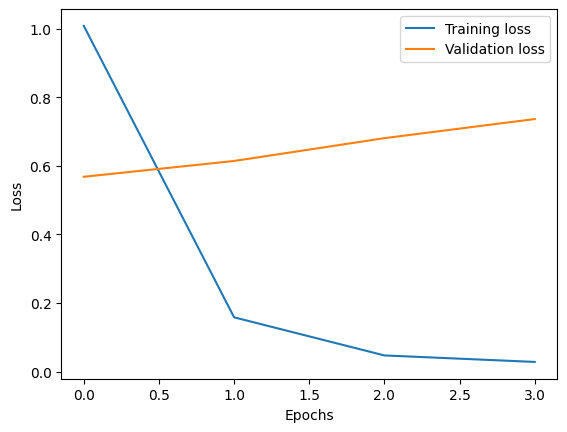

In [49]:
plot_learning_curve(train_losses, valid_losses)

### 13.6 Evaluate the model


In [50]:
predictions, accuracy = evaluate_classnet(net, tfdif_test_dataloader)

Accuracy: 84 %
Precision: 0.15331091365731433
Recall: 0.1562370974742709
F1 Score: 0.15429261814215112


## Task 14: Get Word Embeddings

BoW models, such as TF-IDF, often fail to capture the semantic nuances of words crucial for many NLP tasks. In contrast, word embeddings address these issues by representing words as real-valued vectors learned through unsupervised methods from massive text corpora. Popular examples of word embeddings include GloVe (Global Vectors for Word Representation) and Word2Vec.

In this task, you’ll create feature vectors using GloVe embeddings.

To complete the task, do the following:

1. The GloVe6B embeddings have been downloaded and are in the /glove6B directory.

Load the 200d embeddings from /glove6B/glove.6B.200d.txt into a dictionary named glove_embed_dict with words as keys and their corresponding embedding
vectors as values.

Create two dictionaries: index_to_word, which maps integers to words, and word_to_index which reverses this mapping, associating words with their 
respective integer indexes.

2. There are two tokens that are important in NLP; pad and unk. The pad vectors are added to shorter sequences to ensure they are in the dimension
expected by the model, in a process called padding. The unk token is used to represent words not in the chosen vocabulary.

Add pad and unk tokens into glove_embed_dict. Assign unk a vector of random floats, and pad a vector of zeros with a dimension of 200.

Then, add these tokens to both index_to_word and word_to_index dictionaries, ensuring they map correctly between the token and its newly assigned index.

3. Iterate through your training samples, split them into words, and calculate the average and maximum number of words per sample.

4. Define a custom Dataset, GloveDataset, which will preprocess the data.

In the __init__() method, initialize variables for features and labels. The method accepts the following parameters: text (sequence of lists of space-separated tokens), labels, word_to_index, index_to_word, glove_embed_dict, and max_seq_len. Create self.index_seq to store word indexes for each sequence, assigning the `unk` index for words not found in word_to_index. Limit storage to max_seq_len. Use a default max_seq_len of 20.

Implement the __len__() method to return the total number of samples in the dataset.

Implement the __getitem__() method to fetch, transform, and return the input and target for a given index idx.


### 14.1 Load embeddings into a dictionary

In [51]:
glove_embed_dict = {}
word_to_index = {}
index_to_word = {}
with open('/glove6B/glove.6B.200d.txt','r') as f:
    for index, line in enumerate(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        glove_embed_dict[word] = vector
        index_to_word[index] = word
        word_to_index[word] = index

### 14.2 Add 'pad' and 'unk' tokens to the dictionaries


In [52]:
glove_embed_dict['<unk>'] = np.random.rand(200)
glove_embed_dict['<pad>'] = np.zeros(200)
index = len(glove_embed_dict)+1
word_to_index['<unk>'] = index
index_to_word[index ] = '<unk>'
index +=1
word_to_index['<pad>'] = index
index_to_word[index] = '<pad>'

### 14.3 Calculate average sequence length


In [53]:
total_seq_len = 0
max_seq_len = 0
for line in  train_df['text']: 
    seq_len = len(line.split(" "))
    total_seq_len += seq_len
    max_seq_len = max(max_seq_len, seq_len)
avg_seq_len = total_seq_len/len(train_df['text'])
print(f"Average seq len: {avg_seq_len}")
print(f"Max seq len: {max_seq_len}")

Average seq len: 5.661408657373441
Max seq len: 21


### 14.4 Implement GloveDataset


In [54]:
class GloveDataset(Dataset):
    def __init__(self, text, labels, word_to_index, index_to_word, glove_embed_dict, max_seq_len=20):
        self.labels = torch.tensor(labels.values)
        self.glove_embed_dict = glove_embed_dict
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.max_seq_len = max_seq_len
        self.index_seq = []
        for line in text:
            indices = [self.word_to_index.get(word, self.word_to_index.get('<unk>')) for word in line.split()]
            pad_length = self.max_seq_len - len(indices)
            indices = indices[:self.max_seq_len] + [self.word_to_index.get('<pad>')] * pad_length
            self.index_seq.append(indices)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        indices = self.index_seq[idx]
        label = self.labels[idx]
        words = [self.index_to_word[i] for i in indices]
        embeddings = torch.tensor([self.glove_embed_dict[word] for word in words], dtype=torch.float)
        return embeddings, label

## Task 15: Set up Training

In this task, your primary focus will be on training a neural network using long short-term memory (LSTM) networks, a specialized type of recurrent 
neural networks (RNNs) known for their efficacy in NLP.

To complete the task, do the following:

1. Create a neural network class called GloveClassifier :

Create a constructor method __init__() which will accept input dimension (GloVe embeddings dimension), hidden dimension 
(size of the hidden state vector), output dimension (number of classes), and number of layers (number of LSTM layers).

Initialize an LSTM layer and set the batch_first parameter to True.

Initialize a Linear layer that will take an input whose dimension is the same as the hidden dimension from the LSTM layer.

Implement the forward method. Pass the data through the LSTM and a Linear layer and return the logits.

2. Set the following model and data configurations: input_dim = 200, hidden_dim = 128, output_dim = 6, num_layers = 2, batch_size = 16, 
learning_rate = 0.002, and n_epochs = 10.

3. Instantiate GloveDataset for train-test-validation splits. Set up the corresponding DataLoaders for these datasets.

4. Instantiate a GloveClassifier class with the specified parameters.

5. Instantiate CrossEntropyLoss and Adam optimizer.

6. Move the model to the configured device.


### 15.1 Define a neural network

In [55]:
class GloveClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GloveClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # LSTM layer
        self.linear_layer = nn.Linear(hidden_dim, output_dim)                   # Fully connected layer
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.linear_layer(hn[-1])
        return out

### 15.2 Set model and data configurations


In [56]:
input_dim = 200
hidden_dim = 128
output_dim = 6
num_layers = 2 
batch_size = 16
learning_rate = 0.002
n_epochs = 10

### 15.3 Instantiate datasets and dataloaders


In [57]:
train_dataset = GloveDataset(X_train, y_train, word_to_index, index_to_word, glove_embed_dict)
valid_dataset = GloveDataset(X_valid, y_valid, word_to_index, index_to_word, glove_embed_dict)
test_dataset = GloveDataset(X_test, y_test, word_to_index, index_to_word, glove_embed_dict)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

### 15.4 Instantiate a neural network


In [58]:
model = GloveClassifier(input_dim, hidden_dim, output_dim, num_layers)

### 15.5 Instantiate loss function and optimizer


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 15.6 Move model to device


In [60]:
model.to(device)

GloveClassifier(
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True)
  (linear_layer): Linear(in_features=128, out_features=6, bias=True)
)

## Task 16: Train and Evaluate the Neural Network

In this task, you’ll train and evaluate the model on feature vectors from GloVe embeddings.

To complete the task, do the following:

1. Call the train_nn() function to train the model.

2. Call the plot_learning_curve() function to visualize the learning curve.

3. Call the evaluate_classnet() method to evaluate the model on the test set.


### 16.1 Train the model

In [61]:
train_losses, valid_losses = train_nn(model, optimizer, criterion,  train_dataloader, valid_dataloader, n_epochs = n_epochs)

/tmp/ipykernel_164/2784965799.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  embeddings = torch.tensor([self.glove_embed_dict[word] for word in words], dtype=torch.float)


Finished Training


### 16.2 Plot the learning curve


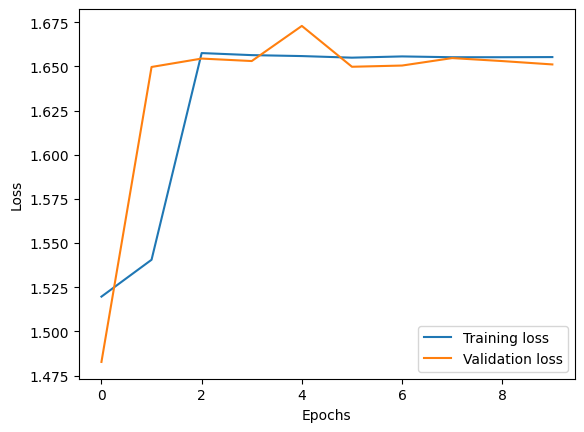

In [62]:
plot_learning_curve(train_losses, valid_losses)

### 16.3 Evaluate the model


In [64]:
predictions, accuracy = evaluate_classnet(model, test_dataloader)

Accuracy: 27 %
Precision: 0.04575818303273213
Recall: 0.16545893719806762
F1 Score: 0.0716902145473574


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Task 17: Get Embeddings from Pretrained Language Models

Static word embedding techniques like GloVe and Word2vec capture word meanings but struggle with context. Pre-trained language models (PLMs) like BERT,
GPT-2, and XLNet overcome this by initially training on large language datasets for general understanding and then fine-tuning on smaller, 
task-specific datasets. For classification tasks, a simple feedforward layer, or classification head, is added to PLMs to make decisions based on this 
contextual information.

In this project, you’ll use MobileBERT, a lightweight version of BERT, via the transformers library.

To complete this task, perform the following steps:

1. Set the following variables: max_len = 64 , batch_size = 32, n_epochs = 3, and learning_rate = 1e-04.

2. Instantiate a MobileBertTokenizer for the google/mobilebert-uncased version of MobileBERT and assign it to a variable named tokenizer. 
The MobileBertTokenizer is a module from transformers library and is in the imports. Learn more about tokenization in this Educative Answer.

3. Implement a custom Dataset, MobileBertDataset, which will preprocess the data.

In the __init__() method, initialize variables for features and labels. The method accepts the following parameters: text (sequence of sentences), 
labels, tokenizer, and max_len.

Implement the __len__() method to return the total number of samples in the dataset.

Implement the __getitem__() method to fetch, transform, and return a label and embeddings for a given index idx. Use the tokenizer to encode the text
and return a dictionary containing ids, mask, and targets as keys.

4. Implement a neural network classifier class named MobileBertClassNet.

Within the constructor method __init__(), initialize the model’s layers.

Download the google/mobilebert-uncased version of MobileBERT model via the transformers library and assign it as the first layer.

For the classification head, initialize a linear layer that accepts an input of size 512 and returns an output of size 6.

Initialize a dropout layer.

Implement the forward method. It should have input_ids and attention_masks as parameters. Pass the data through MobileBERT and feedforward layers.



### 17.1 Define model and data configuration

In [65]:
max_len = 64
batch_size = 32
n_epochs = 3
learning_rate = 1e-04

### 17.2 Instantiate tokenizer


In [66]:
tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

### 17.3 Create custom Dataset


In [67]:
class MobileBertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        text = self.texts.iloc[index]
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.labels.iloc[index], dtype=torch.long)
        }

### 17.4 Implement neural network classifier


In [68]:
class MobileBertClassNet(torch.nn.Module):
    def __init__(self, n_classes=6):
        super(MobileBertClassNet, self).__init__()
        self.l1 = MobileBertModel.from_pretrained("google/mobilebert-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(512, n_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooled_output = hidden_state[:, 0]
        x = self.fc1(self.dropout(pooled_output))
        return x

## Task 18: Set up Training

In this task, you’ll create the training and evaluating functions, datasets, DataLoaders, and instantiate the classification model.

Perform the following steps to complete this task:

1. Implement an evaluation function called evaluate_mobilebert() that receives a model and DataLoader as input, and performs a forward pass. It also
returns the predictions, accuracy, and loss.

2. Implement the train_mobilebert() method that will receive the model, criterion, optimizer, train_dataloader, valid_dataloader, and n_epochs as 
parameters. It’ll perform the forward and backward pass on the model and, then validate it in every epoch. The function will return the training and 
validation losses.

3. Create a train-test-validation split using the raw text. This is because the pre-trained models don’t require extensive preprocessing. The training
size should be 1600 and validation size should be 160. Do not change the testing size.

4. Initialize datasets and DataLoaders for the train-test-validation splits.

5. Create an instance of MobileBertClassNet and move it to the device.

6. Instantiate a CrossEntropyLoss and an Adam optimizer.


### 18.1 Create an evaluation function

In [69]:
def evaluate_mobilebert(model, dataloader):
    with torch.no_grad():
        model.eval()
        total_loss = 0
        total_size = 0
        correct_pred = 0
        predictions = []
        for data in dataloader:
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            labels = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            total_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_size += labels.size(0)
            correct_pred += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
        accuracy = 100 * correct_pred // total_size
        loss = total_loss/len(dataloader)
        print(f'Accuracy : {accuracy} %\tLoss: {loss:.4f}')
        return  {'predictions' :predictions, 'accuracy': accuracy, 'loss': loss}

### 18.2 Creat a training function


In [70]:
def train_mobilebert(model, criterion, optimizer, train_dataloader, valid_dataloader, n_epochs):
    train_losses = []
    valid_losses = []
    len_train_dataloader = len(train_dataloader)
    len_valid_dataloader = len(valid_dataloader)
    for epoch in range(n_epochs):  #loop over the dataset
        total_train_loss = 0.0
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            labels = data['targets'].to(device, dtype = torch.long)
            optimizer.zero_grad() # zero the parameter gradients
            outputs = model(ids, mask) # forward + backward + optimize
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        valid_loss = evaluate_mobilebert(model, valid_dataloader)['loss']
        train_losses.append(total_train_loss/len_train_dataloader)
        valid_losses.append(valid_loss)
    return train_losses, valid_losses

### 18.3 Create data splits


In [71]:
X = train_orig['text']
y = train_df['main_cat']
X_test = test_orig['text']
y_test = test_df['main_cat']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=1600, test_size=160, random_state=42, stratify=y)

### 18.4 Initialize datasets and dataloaders


In [72]:
train_dataset = MobileBertDataset(X_train, y_train, tokenizer, max_len)
valid_dataset = MobileBertDataset(X_valid, y_valid, tokenizer, max_len)
test_dataset = MobileBertDataset(X_test, y_test, tokenizer, max_len)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### 18.5 Instantiate the model


In [73]:
model = MobileBertClassNet()
model.to(device)

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

MobileBertClassNet(
  (l1): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_features=128, out_features=

### 18.6 Initialize loss and optimizer


In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

## Task 19: Train and Evaluate the Neural Network

In this workspace, you’ll avoid fully fine-tuning the model, opting instead to freeze the layers of MobileBERT and train only the classification head.
Full fine-tuning can be memory-intensive and ideally requires a GPU. Freezing parameters won’t update during training. While this method is quicker 
and less demanding on resources, it’s important to note that fully fine-tuning all layers typically delivers better results and is preferred in 
practice.

In this task, you’ll train and evaluate the MobileBertClassNet model.

Perform the following steps to complete this task:

1. Freeze all the parameters of the layers of pre-trained model to speed up training.

2. Print the names of the model layers that are trainable.

3. Call the train_mobilebert() function to train the model.

4. Call the plot_learning_curve() function to visualize the learning curve.

5. Evaluate the neural network on the test set using accuracy as a metric.


### 19.1 Freeze the pretrained layers

In [75]:
for param in model.l1.parameters():
    param.requires_grad = False

### 19.2 Print the names of trainable parameters


In [76]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc1.weight
fc1.bias


### 19.3 Train the model


In [77]:
train_losses, valid_losses = train_mobilebert(model, criterion, optimizer, train_dataloader, valid_dataloader, n_epochs)

Accuracy : 21 %	Loss: 2131234.7750
Accuracy : 22 %	Loss: 775532.8625
Accuracy : 21 %	Loss: 1187166.8875


### 19.4 Plot the learning curve


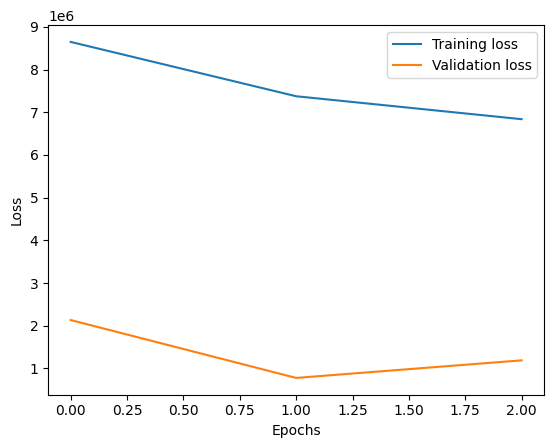

In [78]:
plot_learning_curve(train_losses, valid_losses)

### 19.5 Evaluate the model


In [79]:
results = evaluate_mobilebert(model, test_dataloader)

Accuracy : 27 %	Loss: 1250170.7109


## Task 20: Handle Imbalanced Data

Data imbalance in classification, where certain classes are underrepresented, can impair model performance. The dataset has this issue. To counteract
it, you can follow the methods below:

Generate synthetic data: Use techniques like SMOTE or advanced generative AI for new minority class samples.

Oversample the minority class: Increase minority class representation by replicating its samples.

Undersample the majority class: Reduce majority class samples to balance distribution.

Adjust loss function weights: Increase penalties for misclassifying minority classes to focus model learning.

Apply transfer learning: Start with models pre-trained on diverse datasets for better initial learning.

In this task, you’ll set weights to the loss function to enhance the model’s sensitivity to the minority class. This approach aims to mitigate the 
effects of data imbalance and improve overall performance.

Do the following steps to complete this task:

1. Determine the class distribution percentages for both the training and testing splits.

2. Implement a get_class_weight() function. This function will take encoded class values (y) and return two things: a dictionary mapping each class to 
its calculated weight and a list of these weights sorted according to class (e.g., index 0 will contain the weight for class 0).

3. Call get_class_weight() to return a list of class weights, transform the list into a PyTorch tensor, and move it to the configured device.

4. Then, initialize a CrossEntropyLoss object, passing in the tensor list of class weights as an argument and assigning it to a variable named 
criterion.

                                                                 


### 20.1 Calculate class distributions

In [80]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

main_cat
2    0.229375
3    0.224375
1    0.213125
5    0.164375
4    0.153125
0    0.015625
Name: count, dtype: float64
main_cat
1    0.276
5    0.226
2    0.188
4    0.162
3    0.130
0    0.018
Name: count, dtype: float64


### 20.2 Implement get_class_weight()


In [81]:
def get_class_weight(y_split):
    class_list = np.unique(y_split)
    class_weight_value = compute_class_weight(class_weight='balanced', classes=class_list, y=y_split)
    weight_dict = {}
    weight_list = []
    for i in range(len(class_list)):
        weight_dict[class_list[i]] = class_weight_value[i]
        weight_list.append(class_weight_value[i])
    return weight_dict, weight_list

### 20.3 Create class weight tensors


In [82]:
weight_dict, weight_list = get_class_weight(y_train)
class_weights = torch.tensor(weight_list, dtype=torch.float32)
class_weights = class_weights.to(device)

### 20.4 Initialize CrossEntropyLoss with class weighting


In [83]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Task 21: Train and Evaluate the Neural Network

To explore how class weighting affects performance, you’ll retrain a new instance of ClassificationNet using TF-IDF vectors. Every hyperparameter will be the same as the previous iteration except for a loss function with class weighting.

To complete this task, do the following:

1. Instantiate the ClassificationNet class and assign the resulting object to a variable named net. Create an Adam optimizer with a learning rate 
of 0.002.

2. Move the model to the configured computing device.

3. Call the train_nn() method to train the model. For its parameters, reuse the datasets and DataLoaders you defined for TfidfDataset and n_epochs=4.

4. Call the plot_learning_curve() function to visualize the learning curve.

5. Call the evaluate_classnet() function to evaluate the model on the test set using precision, recall, F1, and accuracy as metrics.



### 21.1 Instantiate classifier and optimizer

In [84]:
net = ClassificationNet()
optimizer = optim.Adam(net.parameters(), lr=0.002)

### 21.2 Move model to device


In [85]:
net.to(device)

ClassificationNet(
  (fc1): Linear(in_features=8000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

### 21.3 Train model


In [86]:
train_losses, valid_losses = train_nn(net, optimizer, criterion, tfdif_train_dataloader, tfdif_valid_dataloader, n_epochs = n_epochs)

Finished Training


### 21.4 Plot learning curve


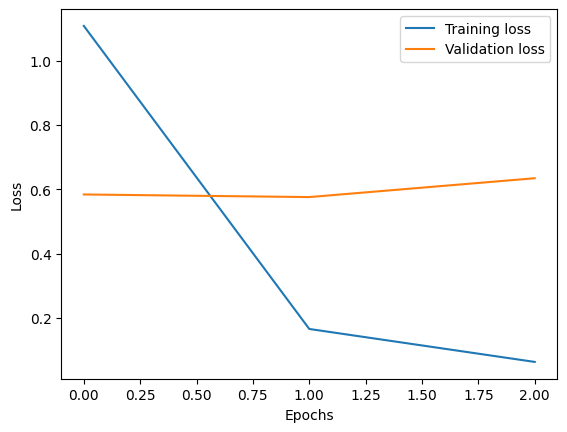

In [87]:
plot_learning_curve(train_losses, valid_losses)

### 21.5 Evaluate model


In [88]:
predictions, accuracy = evaluate_classnet(net, tfdif_test_dataloader)

Accuracy: 64 %
Precision: 0.13058579492403022
Recall: 0.17463535285292517
F1 Score: 0.11732250566978804


## Task 22: Save a Neural Network

You’ll now review the metrics of the four neural networks you trained to identify the top performers. To enhance them, explore hyperparameter tuning, 
data augmentation, or architecture changes. You can save PyTorch models by serializing their state_dict. Also, save checkpoints during training for
future training continuation or inference.

In this task, you’ll save and load the classifier.

To complete the task, do the following:

1. Save the previous TF-IDF model to a file named tfidf_model.pt.

2. Initialize a new ClassificationNet model named loaded_model. Load the saved model file to this variable.



### 22.1 Save the model

In [89]:
path = "/usercode/tfidf_model.pt"
torch.save(net.state_dict(), path)

### 21.2 Load the model


In [90]:
loaded_model = ClassificationNet()
loaded_model.load_state_dict(torch.load(path))

<All keys matched successfully>